In [1]:
%load_ext autoreload
%autoreload 2

%cd ..

/home/rainorangelemon/Documents/Attend-and-Excite


/home/rainorangelemon/micromamba/envs/sam2/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import pandas as pd
df = pd.read_csv("outputs/weak_lift/a black car and a white clock.csv")
df

annotation_id  annotator                      choice  \
0               5          1  black car + no white clock   
1               6          1  no black car + white clock   
2               7          1  no black car + white clock   
3               8          1     black car + white clock   
4               9          1  black car + no white clock   
..            ...        ...                         ...   
95            100          1     black car + white clock   
96            101          1  black car + no white clock   
97            102          1  black car + no white clock   
98            103          1     black car + white clock   
99            104          1  black car + no white clock   

                     created_at   id                           image  \
0   2024-11-23T20:16:37.546250Z    5  /data/upload/2/eada8f85-93.png   
1   2024-11-23T20:16:45.530697Z    6  /data/upload/2/2f69c4b1-99.png   
2   2024-11-23T20:16:55.738783Z    7  /data/upload/2/caec6475-98.png   
3   2024-11-23T20:17:01.022866Z    8  /data/upload/2/88dc3e2d-97.png   
4   2024-11-23T20:17:07.715115Z    9  /data/upload/2/b38e49c5-96.png   
..                          ...  ...                             ...   
95  2024-11-23T20:25:49.990535Z  100   /data/upload/2/c28ad969-4.png   
96  2024-11-23T20:26:02.305544Z  101   /data/upload/2/626af78e-3.png   
97  2024-11-23T20:26:04.896511Z  102   /data/upload/2/329df856-2.png   
98  2024-11-23T20:26:08.722558Z  103   /data/upload/2/9edf9d09-1.png   
99  2024-11-23T20:26:11.604994Z  104   /data/upload/2/61393c67-0.png   

    lead_time                   updated_at  
0      41.553  2024-11-23T20:16:37.546265Z  
1       7.795  2024-11-23T20:16:45.530713Z  
2      10.095  2024-11-23T20:16:55.738802Z  
3       5.150  2024-11-23T20:17:01.022882Z  
4       6.549  2024-11-23T20:17:07.715130Z  
..        ...                          ...  
95      1.504  2024-11-23T20:25:49.990552Z  
96     12.177  2024-11-23T20:26:02.305564Z  
97      2.448  2024-11-23T20:26:04.896530Z  
98      3.691  2024-11-23T20:26:08.722572Z  
99      2.739  2024-11-23T20:26:11.605010Z  

[100 rows x 8 columns]

In [3]:
# calculate the average lead time
is_black_car = (df["choice"] == "black car + white clock") | (df["choice"] == "black car + no white clock")
is_white_clock = (df["choice"] == "black car + white clock") | (df["choice"] == "no black car + white clock")

print(is_black_car.mean(), is_white_clock.mean())

0.86 0.62


In [4]:
def clean_object_name(object_name):
    if "a " in object_name:
        return object_name.split("a ")[1]
    else:
        return object_name

# do similar analysis for the other prompts: a frog and a mouse, a turtle with a bow
for prompt in ["a black car and a white clock", "a frog and a mouse", "a turtle with a bow"]:
    df = pd.read_csv(f"outputs/weak_lift/{prompt}.csv")
    if "with" in prompt:
        split_prompt = prompt.split("with")
    else:
        split_prompt = prompt.split("and")
    object_1 = split_prompt[0].strip()
    object_2 = split_prompt[1].strip()
    object_1 = clean_object_name(object_1)
    object_2 = clean_object_name(object_2)
    is_object_1 = (df["choice"] == f"{object_1} + {object_2}") | (df["choice"] == f"{object_1} + no {object_2}")
    is_object_2 = (df["choice"] == f"{object_1} + {object_2}") | (df["choice"] == f"no {object_1} + {object_2}")
    print(f"{object_1}:", is_object_1.mean(), f"{object_2}:", is_object_2.mean())

black car: 0.86 white clock: 0.62
frog: 1.0 mouse: 0.18
turtle: 1.0 bow: 0.33


In [5]:
# check the pt file
df = pd.read_csv("outputs/weak_lift/a black car and a white clock.csv")
# get the image names
image_names = df["image"].tolist()
image_ids = [int(image_name.split("-")[-1].split(".")[0]) for image_name in image_names]
# sort df using the image ids from 0 to 99, in increasing order
df = df.sort_values(by="image", key=lambda x: [int(image_name.split("-")[-1].split(".")[0]) for image_name in x])
# get the label for whether the object is white clock
is_white_clock = (df["choice"] == "black car + white clock") | (df["choice"] == "no black car + white clock")

import torch
all_lift_results = torch.zeros(100, 2, 200)
all_final_latents = torch.zeros(100, 4, 128, 128)
all_intermediate_latents = torch.zeros(100, 50, 4, 128, 128)
for i in range(100):
    lift_results = torch.load(f"outputs/weak_lift/a black car and a white clock/{i}_lift_results.pt", weights_only=True)
    all_lift_results[i] = lift_results["log_lift_results"]
    all_final_latents[i] = lift_results["latents"]
    all_intermediate_latents[i] = torch.stack(lift_results["intermediate_latents"]).squeeze(1)
print(all_lift_results.shape)

logc_given_x = all_lift_results[:, 1].mean(dim=-1)
label_pred = (logc_given_x > 0)
print(label_pred.shape)
print(label_pred.float().mean())

torch.Size([100, 2, 200])
torch.Size([100])
tensor(1.)


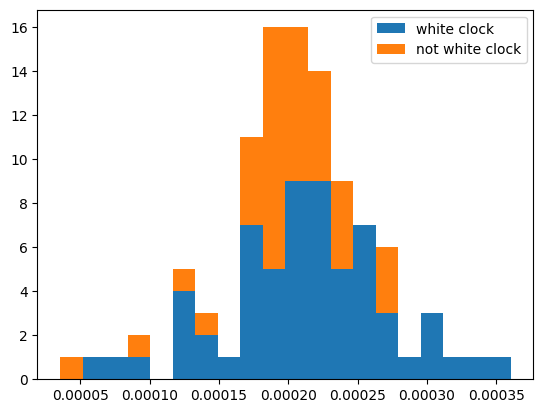

In [6]:
# print the histogram of the logc_given_x, with stacked style
import matplotlib.pyplot as plt
logc_given_x_is_white_clock = logc_given_x[is_white_clock]
logc_given_x_is_not_white_clock = logc_given_x[~is_white_clock]
plt.hist([logc_given_x_is_white_clock, logc_given_x_is_not_white_clock], stacked=True, label=["white clock", "not white clock"], bins=20)
plt.legend()
plt.show()

In [7]:
from diffusers import DiffusionPipeline
import torch
pipeline = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True)
pipeline.to("cuda")
pipeline.unet = torch.compile(pipeline.unet, mode="max-autotune", fullgraph=True)
# offload vae and text encoder
pipeline.vae.to("cpu");

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [8]:
from typing import List, Optional, Dict, Any, Union
from diffusers import StableDiffusionPipeline, StableDiffusionXLPipeline, DDPMScheduler
from lift_callback import LiftCallback
from tqdm import trange

@torch.inference_mode()
def calculate_score(latents,
                    callback: LiftCallback,
                    pipeline: Union[StableDiffusionPipeline, StableDiffusionXLPipeline],
                    prompts: List[str],
                    noise: Optional[torch.Tensor] = None,
                    timesteps: Optional[torch.Tensor] = None,
                    cross_attention_kwargs: Optional[Dict[str, Any]] = None,
):

    config = callback.config

    # Compile the unet, might take a while at the first run
    unet = pipeline.unet
    # unet = torch.compile(pipeline.unet, mode="max-autotune")

    device = latents.device
    # print whether the scheduler uses v-prediction or epsilon or others
    assert pipeline.scheduler.config.prediction_type == "epsilon", "Only epsilon prediction is supported for unet"
    scheduler = DDPMScheduler(beta_schedule="scaled_linear", beta_start=0.00085, beta_end=0.012)
    # set scheduler to training mode
    scheduler.set_timesteps(num_inference_steps=1000, device="cuda")

    # Get the UNet's dtype
    unet_dtype = pipeline.unet.dtype

    # Convert latents to UNet's dtype
    latents = latents.to(dtype=unet_dtype)

    n_prompts = len(prompts)
    # -> (n_trials,)
    B, *latent_shape = latents.shape
    if noise is None:
        noise = callback.get_noise(latent_shape).to(device, dtype=unet_dtype)
    else:
        noise = noise.to(device, dtype=unet_dtype)
    if timesteps is None:
        ts = callback.get_timesteps(scheduler).to(device)
    else:
        ts = timesteps.to(device)
    # -> (n_trials, *Latent_shape)
    num_latent_dims = len(latents.shape) - 1

    score_results = torch.zeros((B, n_prompts, len(ts), *latent_shape), dtype=unet_dtype)

    image_idxs = torch.arange(B, device=device)[:, None, None].expand(-1, n_prompts, len(ts)).flatten().to(device)
    algebra_idxs = torch.arange(n_prompts, device=device)[None, :, None].expand(B, -1, len(ts)).flatten().to(device)
    trial_idxs = torch.arange(len(ts), device=device)[None, None, :].expand(B, n_prompts, -1).flatten().to(device)

    idx = 0
    for _ in trange(len(trial_idxs) // config.batch_size + int(len(trial_idxs) % config.batch_size != 0), leave=False):
        current_latents = latents[image_idxs[idx:idx + config.batch_size]]
        current_prompts = [prompts[idx] for idx in algebra_idxs[idx:idx + config.batch_size]]
        current_noise = noise[trial_idxs[idx:idx + config.batch_size]]
        current_ts = ts[trial_idxs[idx:idx + config.batch_size]]

        noisy_latents = scheduler.add_noise(current_latents, current_noise, current_ts)

        # Double the batch size to add unconditional prediction
        latent_model_input = noisy_latents
        t = current_ts

        # Encode input prompt
        if isinstance(pipeline, StableDiffusionPipeline):
            prompt_embeds, _ = pipeline.encode_prompt(
                current_prompts,
                device=device,
                num_images_per_prompt=1,
                do_classifier_free_guidance=False,
            )
            current_prompt_embeds = prompt_embeds
            # predict the noise residual
            noise_pred = unet(
                latent_model_input,
                t,
                encoder_hidden_states=current_prompt_embeds,
                cross_attention_kwargs=cross_attention_kwargs,
                return_dict=False,
            )[0]

        elif isinstance(pipeline, StableDiffusionXLPipeline):
            # Encode input prompt
            (prompt_embeds, _, pooled_prompt_embeds, _) = pipeline.encode_prompt(
                current_prompts,
                device=device,
                num_images_per_prompt=1,
                do_classifier_free_guidance=False,
            )

            # Get timestep conditioning
            timestep_cond = None
            if pipeline.unet.config.time_cond_proj_dim is not None:
                guidance_scale_tensor = torch.tensor(pipeline.guidance_scale - 1).repeat(len(current_ts))
                timestep_cond = pipeline.get_guidance_scale_embedding(
                    guidance_scale_tensor,
                    embedding_dim=pipeline.unet.config.time_cond_proj_dim
                ).to(device=device, dtype=latent_model_input.dtype)

            # Get added time IDs conditioning
            add_text_embeds = pooled_prompt_embeds
            text_encoder_projection_dim = (
                pipeline.text_encoder_2.config.projection_dim
                if pipeline.text_encoder_2 is not None
                else int(pooled_prompt_embeds.shape[-1])
            )
            add_time_ids = pipeline._get_add_time_ids(
                original_size=(1024, 1024),
                crops_coords_top_left=(0, 0),
                target_size=(1024, 1024),
                dtype=prompt_embeds.dtype,
                text_encoder_projection_dim=text_encoder_projection_dim
            ).to(device)
            add_time_ids = add_time_ids.to(device).repeat(len(current_ts), 1)

            added_cond_kwargs = {"text_embeds": add_text_embeds, "time_ids": add_time_ids}

            latent_model_input = scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            noise_pred = unet(
                latent_model_input,
                t,
                encoder_hidden_states=prompt_embeds,
                timestep_cond=timestep_cond,
                cross_attention_kwargs=cross_attention_kwargs,
                added_cond_kwargs=added_cond_kwargs,
                return_dict=False,
            )[0]

        noise_pred_text = noise_pred
        # -> (batch_size,)
        score_results[image_idxs[idx:idx + config.batch_size],
                            algebra_idxs[idx:idx + config.batch_size],
                            trial_idxs[idx:idx + config.batch_size]] = noise_pred_text.cpu()

        idx += len(current_ts)
    return score_results

In [9]:
ddpm_scheduler = DDPMScheduler(beta_schedule="scaled_linear", beta_start=0.00085, beta_end=0.012)

pipeline.scheduler.set_timesteps(num_inference_steps=50, device="cuda")
sqrt_alpha_prod = ddpm_scheduler.alphas_cumprod ** 0.5
sqrt_one_minus_alpha_prod = (1 - ddpm_scheduler.alphas_cumprod) ** 0.5
prev_t = pipeline.scheduler.timesteps[1:]
x0 = all_intermediate_latents[:, -1]
scaled_x0 = torch.einsum("t, b c h w -> b t c h w", sqrt_alpha_prod[prev_t.cpu().long()], x0)

pipeline.scheduler.set_timesteps(timesteps=prev_t.long().cpu(), num_inference_steps=None)
sigma = pipeline.scheduler.sigmas.to(prev_t.device)[:-1]
intended_noise = (all_intermediate_latents[:, :-1] - x0[:, None]) / sigma[:, None, None, None].to(all_intermediate_latents.device)

In [10]:
scaled_intermediate_latents = all_intermediate_latents[:, :-1] / ((sigma**2 + 1) ** 0.5)[:, None, None, None].to(all_intermediate_latents.device)
(ddpm_scheduler.add_noise(x0, intended_noise[:, 1], prev_t[1].long()) - scaled_intermediate_latents[:, 1]).abs().max()

tensor(4.7684e-07)

In [11]:
from lift_callback import LiftCallback
from config import LiftConfig
from tqdm import tqdm
config = LiftConfig(prompt="a black car and a white clock", subtract_unconditional=False,
                    batch_size=8,
                    same_noise=False,
)
callback = LiftCallback(config)

score_black_car_and_white_clock_all = []
score_black_car_all = []
score_white_clock_all = []
score_uncond_all = []
latest_latents = all_final_latents.to("cuda:0")
for img_idx in tqdm(range(10)):
    score_results = calculate_score(latest_latents[[img_idx]],
                                    callback,
                                    pipeline,
                                    prompts=["a black car and a white clock", "a black car", "a white clock", ""],
                                    noise=intended_noise[img_idx],
                                    timesteps=prev_t.long(),
                                    )
    score_black_car_and_white_clock_all.append(score_results[:, 0])
    score_black_car_all.append(score_results[:, 1])
    score_white_clock_all.append(score_results[:, 2])
    score_uncond_all.append(score_results[:, 3])

score_black_car_and_white_clock_all = torch.cat(score_black_car_and_white_clock_all, dim=0)
score_black_car_all = torch.cat(score_black_car_all, dim=0)
score_white_clock_all = torch.cat(score_white_clock_all, dim=0)
score_uncond_all = torch.cat(score_uncond_all, dim=0)

100%|██████████| 10/10 [02:32<00:00, 15.29s/it]


100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


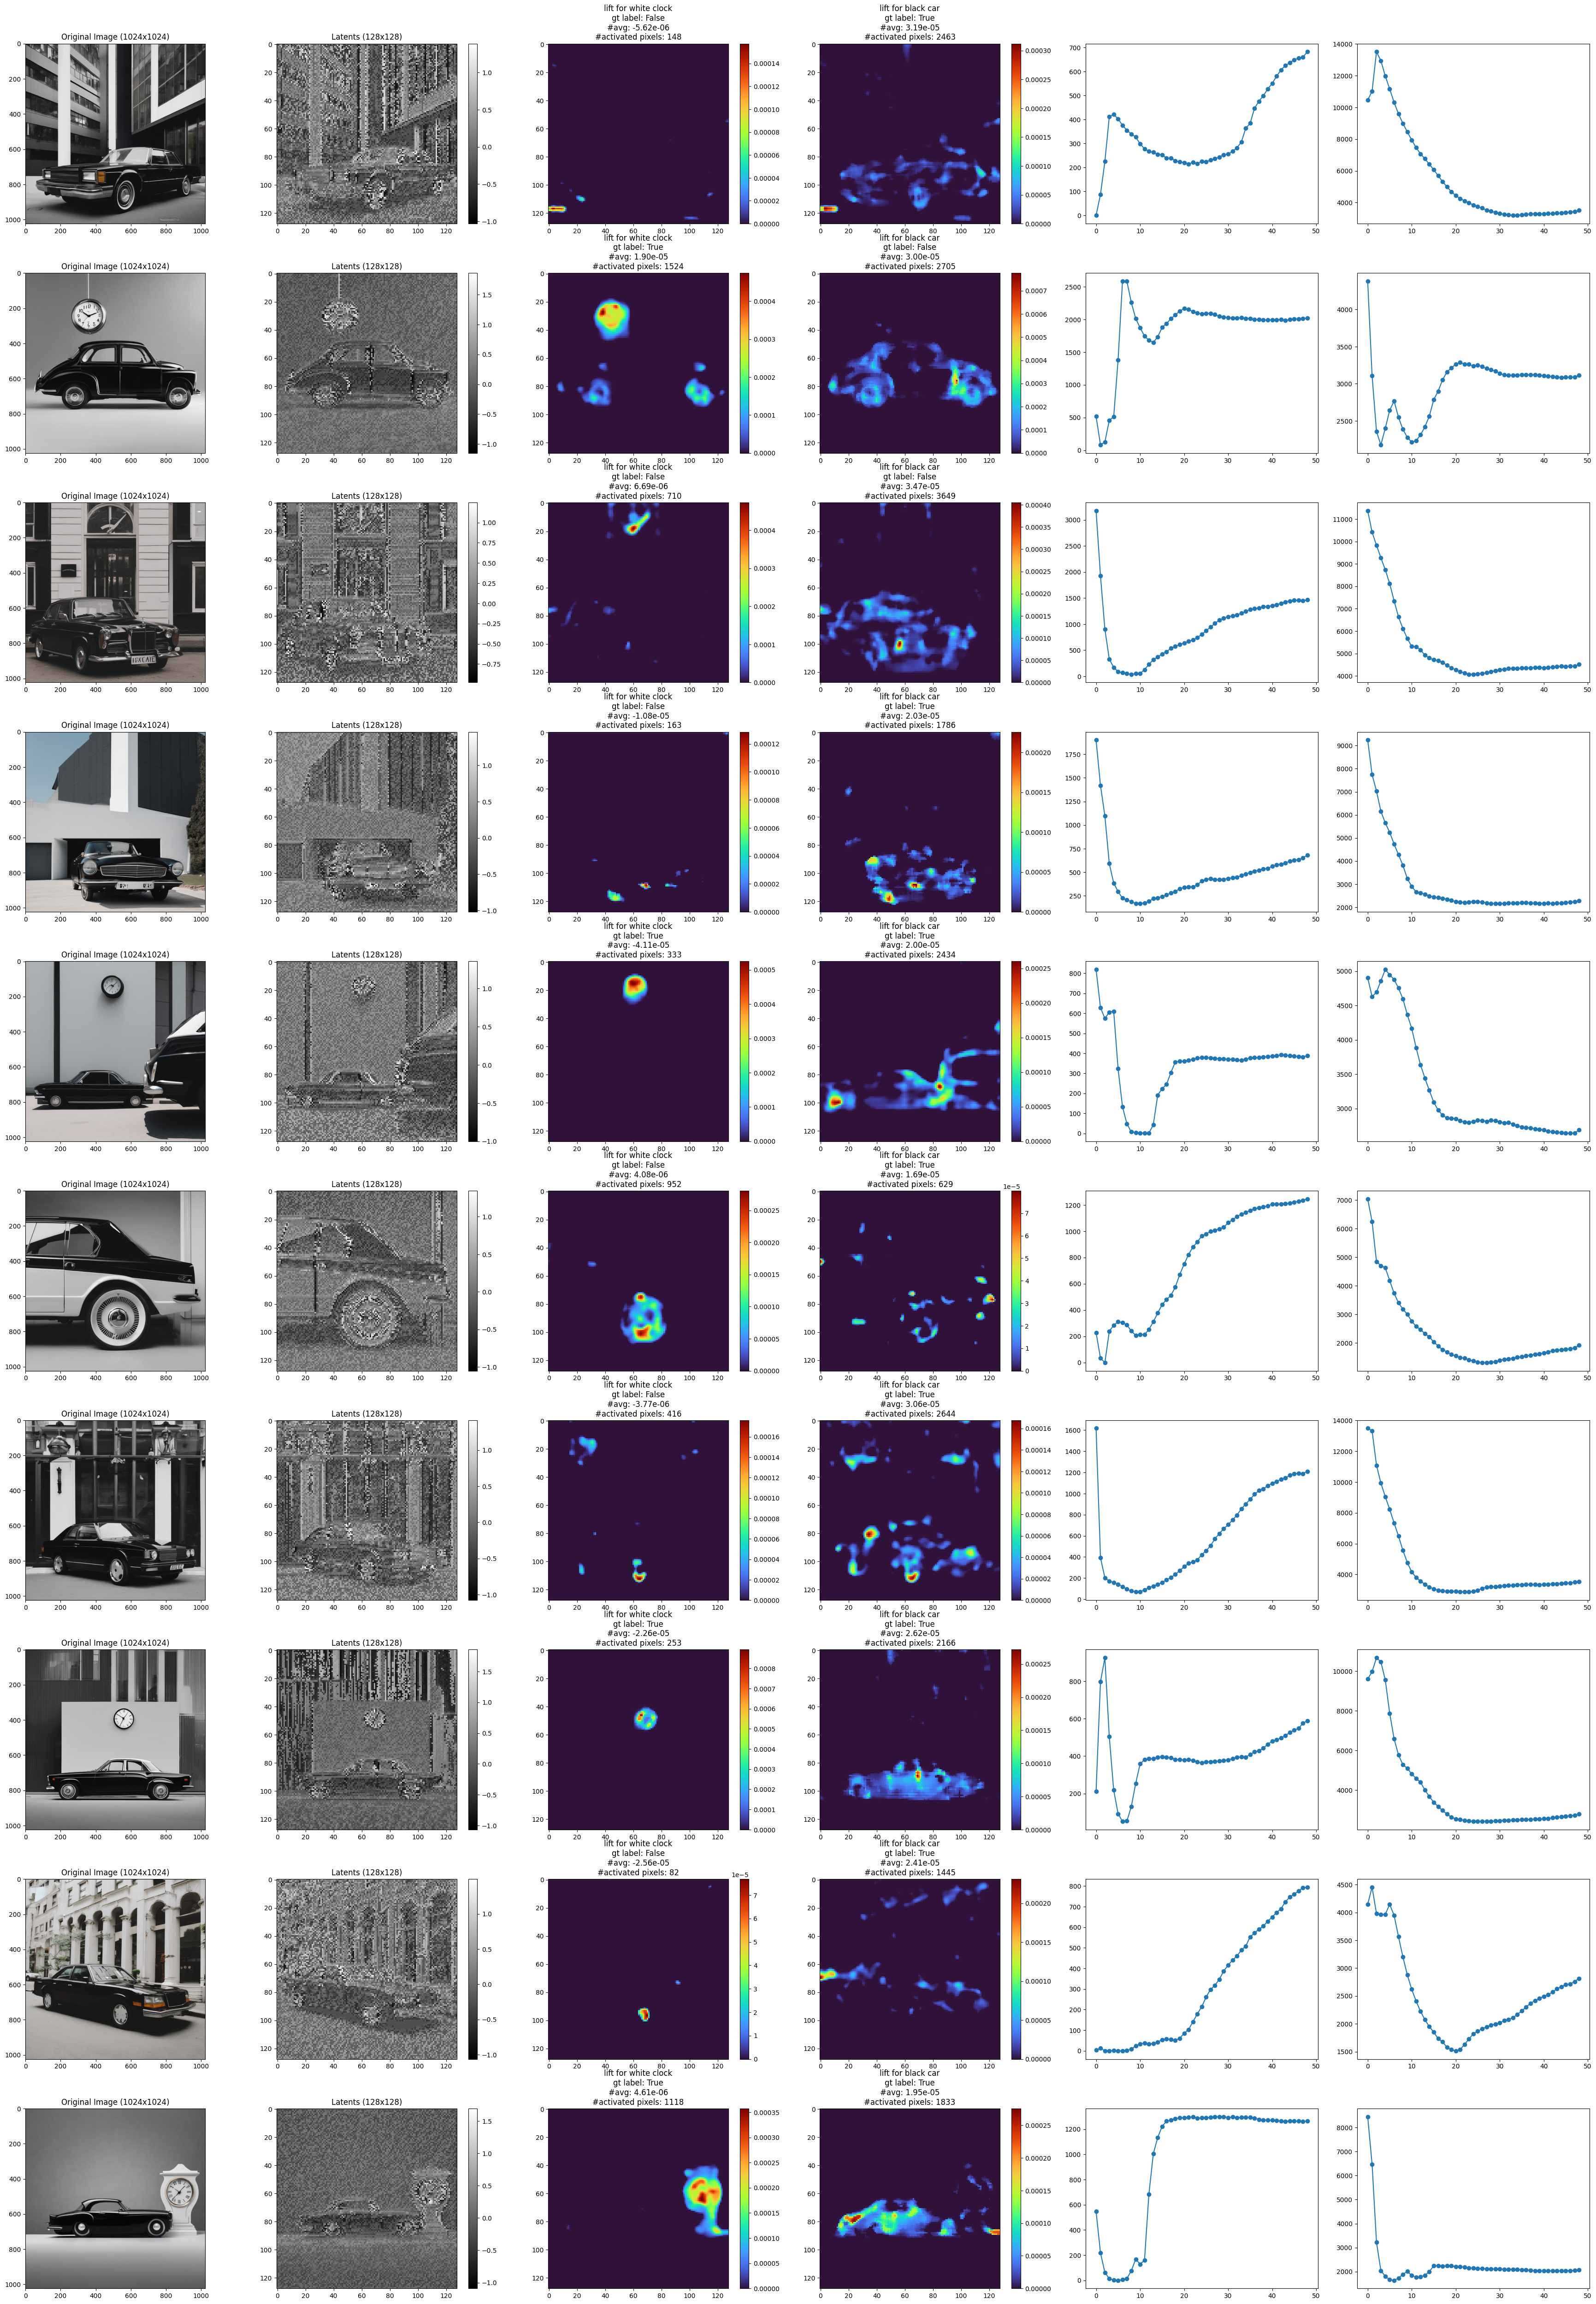

In [35]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import GaussianBlur

# noise = intended_noise[:10]
noise = callback.get_noise([4, 128, 128])[:config.n_samples]
use_gaussian_smoothing = True
draw_pure_lift = False
base = "composed"
# logp_uncond_all = (score_uncond_all - noise).pow(2)
# logp_black_car_and_white_clock_all = (score_black_car_and_white_clock_all - noise).pow(2)
# logp_white_clock_all = (score_white_clock_all - noise).pow(2)
# logp_black_car_all = (score_black_car_all - noise).pow(2)

threshold1 = 5e-5
threshold2 = 5e-5

if base == "composed":
    base_to_test = score_black_car_and_white_clock_all
elif base == "noise":
    base_to_test = noise
elif base == "uncond":
    base_to_test = score_uncond_all


import torch
import torch.nn.functional as F
from scipy import ndimage
import numpy as np


def apply_median_filter(tensor, kernel_size=3):
    """
    Apply median filter to a PyTorch tensor
    
    Parameters:
    - tensor: Input PyTorch tensor
    - kernel_size: Size of the median filter kernel (default: 3)
    
    Returns:
    - Filtered tensor
    """
    # Store original device
    device = tensor.device
    
    # Convert to numpy array, ensuring it's float32
    if tensor.dim() == 2:
        numpy_array = tensor.detach().cpu().float().numpy()
    else:
        numpy_array = tensor.detach().cpu().float().squeeze().numpy()
    
    # Ensure the array is contiguous and in the correct format
    numpy_array = np.ascontiguousarray(numpy_array)
    
    # Apply median filter
    filtered = ndimage.median_filter(numpy_array, size=kernel_size)
    
    # Convert back to torch tensor
    return torch.from_numpy(filtered).float().to(device)


plt.clf()
plt.close("all")
_, ax = plt.subplots(10, 6, figsize=(35, 50))
for idx in tqdm(range(10)):
    # read the image
    image = Image.open(f"outputs/weak_lift/a black car and a white clock/{idx}.png")
    ax[idx][0].imshow(image)
    ax[idx][0].set_title("Original Image (1024x1024)")

    latents = latest_latents[idx].mean(dim=0)
    # plot the heatmap
    im2 = ax[idx][1].imshow(latents.cpu().numpy(), cmap="gray")
    plt.colorbar(im2, ax=ax[idx][1])
    ax[idx][1].set_title("Latents (128x128)")

    # heatmap = (score_black_car_and_white_clock_all - score_black_car_all).pow(2).mean(dim=1)[idx][-1]
    # heatmap_rectified = heatmap.clone()
    # heatmap_rectified[heatmap_rectified < 0] = 0
    # # plot the heatmap
    # im3 = ax[2].imshow(heatmap_rectified.cpu().numpy(), cmap="hot")
    # plt.colorbar(im3, ax=ax[2])
    # ax[2].set_title(f"white clock: {is_white_clock.values[idx]}, heatmap mean: {heatmap.mean().item():.2e}")

    if draw_pure_lift:
        if base == "composed":
            heatmap = (score_black_car_all - base_to_test).pow(2).mean(dim=(1, 2))[idx]
        elif base == "noise":
            heatmap = ((score_uncond_all - noise).pow(2) - (score_black_car_all - noise).pow(2)).mean(dim=(1, 2))[idx]
        else:
            heatmap = (score_white_clock_all - base_to_test).pow(2).mean(dim=(1, 2))[idx]
    else:
        heatmap = ((base_to_test - score_uncond_all).pow(2) - (base_to_test - score_white_clock_all).pow(2)).mean(dim=(1, 2))[idx]
    if use_gaussian_smoothing:
        heatmap = apply_median_filter(heatmap, kernel_size=5)
        heatmap = GaussianBlur(kernel_size=3)(heatmap[None].float())[0]
    else:
        heatmap = apply_median_filter(heatmap, kernel_size=5)
        
    # plot the heatmap
    im4 = ax[idx][2].imshow(((heatmap - threshold1).relu()).cpu().numpy(), cmap="turbo")
    plt.colorbar(im4, ax=ax[idx][2])
    ax[idx][2].set_title(f"lift for white clock\ngt label: {is_white_clock.values[idx]}\n#avg: {heatmap.mean().item():.2e}\n#activated pixels: {(heatmap > threshold1).sum().item()}")

    if draw_pure_lift:
        if base == "composed":
            heatmap = (score_white_clock_all - base_to_test).pow(2).mean(dim=(1, 2))[idx]
        elif base == "noise":
            heatmap = ((score_uncond_all - noise).pow(2) - (score_white_clock_all - noise).pow(2)).mean(dim=(1, 2))[idx]
        else:
            heatmap = (score_black_car_all - base_to_test).pow(2).mean(dim=(1, 2))[idx]
    else:
        heatmap = ((base_to_test - score_uncond_all).pow(2) - (base_to_test - score_black_car_all).pow(2)).mean(dim=(1, 2))[idx]
    if use_gaussian_smoothing:
        heatmap = apply_median_filter(heatmap, kernel_size=5)
        heatmap = GaussianBlur(kernel_size=3)(heatmap[None].float())[0]
    else:
        heatmap = apply_median_filter(heatmap, kernel_size=5)        
    # plot the heatmap
    im5 = ax[idx][3].imshow(((heatmap - threshold2).relu()).cpu().numpy(), cmap="turbo")
    plt.colorbar(im5, ax=ax[idx][3])
    ax[idx][3].set_title(f"lift for black car\ngt label: {is_black_car.values[idx]}\n#avg: {heatmap.mean().item():.2e}\n#activated pixels: {(heatmap > threshold2).sum().item()}")

    # lift_o_black_car_and_white_clock = (score_black_car_and_white_clock_all - score_white_clock_all).pow(2).mean(dim=(1, 2))
    # lift_o_black_car = (score_black_car_and_white_clock_all - score_black_car_all).pow(2).mean(dim=(1, 2))
    # lift_o_white_clock = (score_black_car_and_white_clock_all - score_white_clock_all).pow(2).mean(dim=(1, 2))
    # lift_o_uncond = (score_black_car_and_white_clock_all - score_uncond_all).pow(2).mean(dim=(1, 2))
    # heatmap = ((lift_o_uncond < lift_o_black_car) & (lift_o_uncond < lift_o_white_clock))[idx]
    # diff_over_time = ((base_to_test - score_black_car_all).pow(2) - (base_to_test - score_white_clock_all).pow(2)).mean(dim=2).flatten(2, 3).max(dim=-1).values[idx]
    diff_along_trajectory = ((base_to_test - score_uncond_all).pow(2) - (base_to_test - score_white_clock_all).pow(2))[idx]
    if use_gaussian_smoothing:
        diff_along_trajectory = GaussianBlur(kernel_size=3)(diff_along_trajectory.float())
    else:
        heatmap = apply_median_filter(heatmap, kernel_size=3)        
    diff_over_time = ((diff_along_trajectory.cumsum(dim=0) / torch.arange(1, diff_along_trajectory.shape[0] + 1)[:, None, None, None].to(diff_along_trajectory.device)).mean(dim=1).flatten(1, 2) > threshold1).sum(dim=-1)
    ax[idx][4].plot(diff_over_time.cpu().numpy(), marker='o')
    # ax[idx][4].set_title(f"lift for black car\ngt label: {is_black_car.values[idx]}\n#activated pixels: {(heatmap > 0).sum().item()}")

    diff_along_trajectory = ((base_to_test - score_uncond_all).pow(2) - (base_to_test - score_black_car_all).pow(2))[idx]
    if use_gaussian_smoothing:
        diff_along_trajectory = GaussianBlur(kernel_size=3)(diff_along_trajectory.float())
    else:
        heatmap = apply_median_filter(heatmap, kernel_size=3)        
    diff_over_time = ((diff_along_trajectory.cumsum(dim=0) / torch.arange(1, diff_along_trajectory.shape[0] + 1)[:, None, None, None].to(diff_along_trajectory.device)).mean(dim=1).flatten(1, 2) > threshold2).sum(dim=-1)
    ax[idx][5].plot(diff_over_time.cpu().numpy(), marker='o')

plt.tight_layout()
plt.savefig("a black car and a white clock.png")

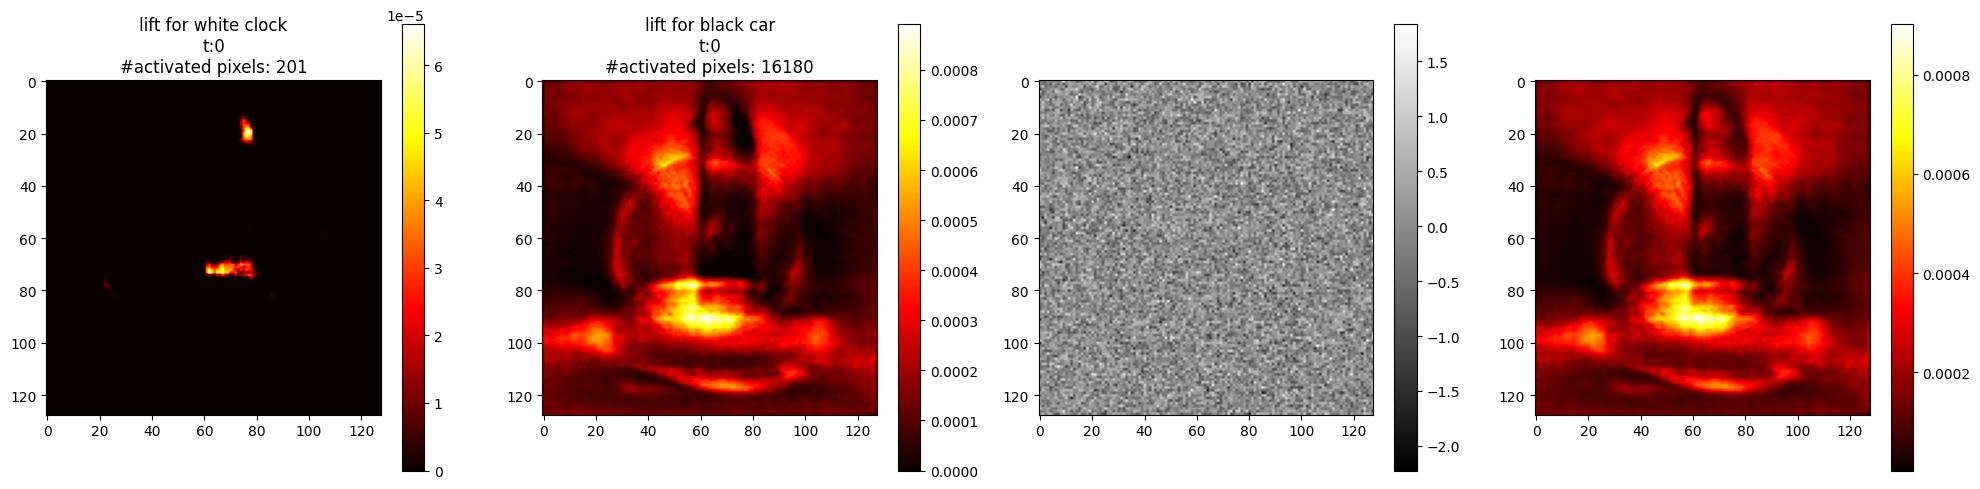

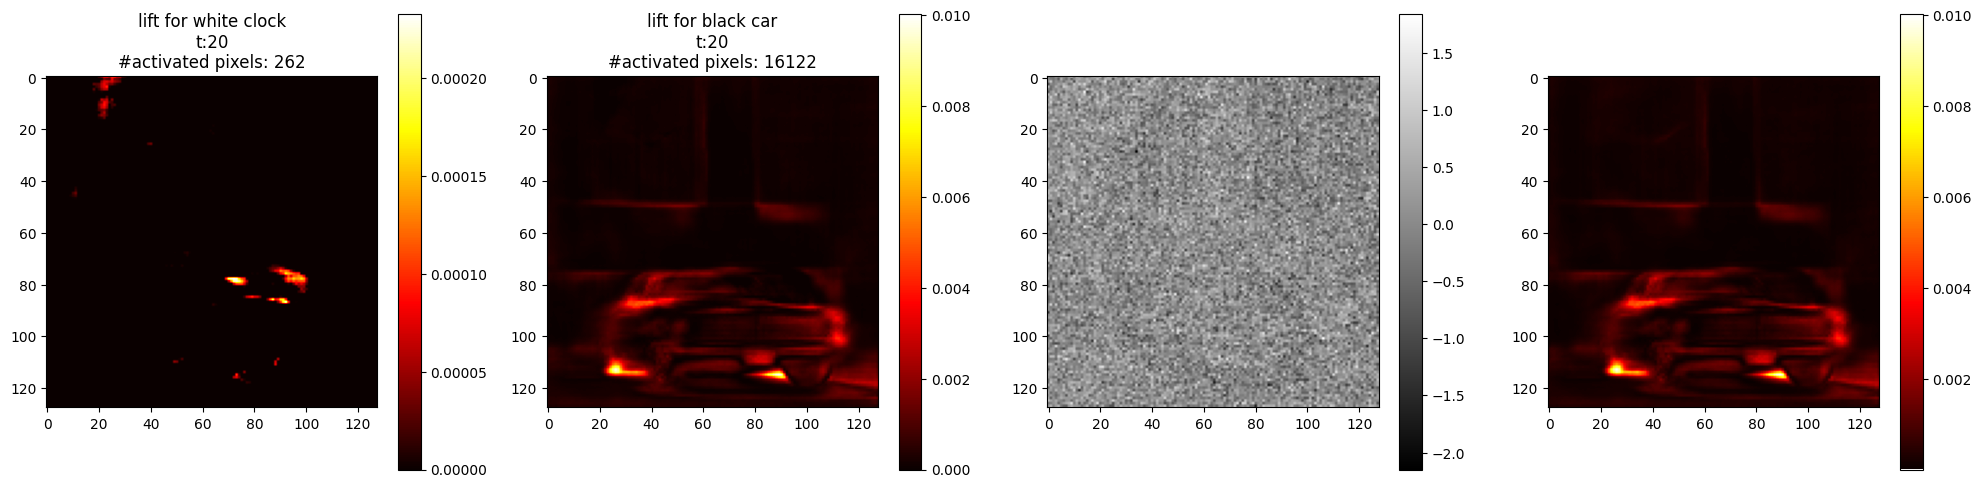

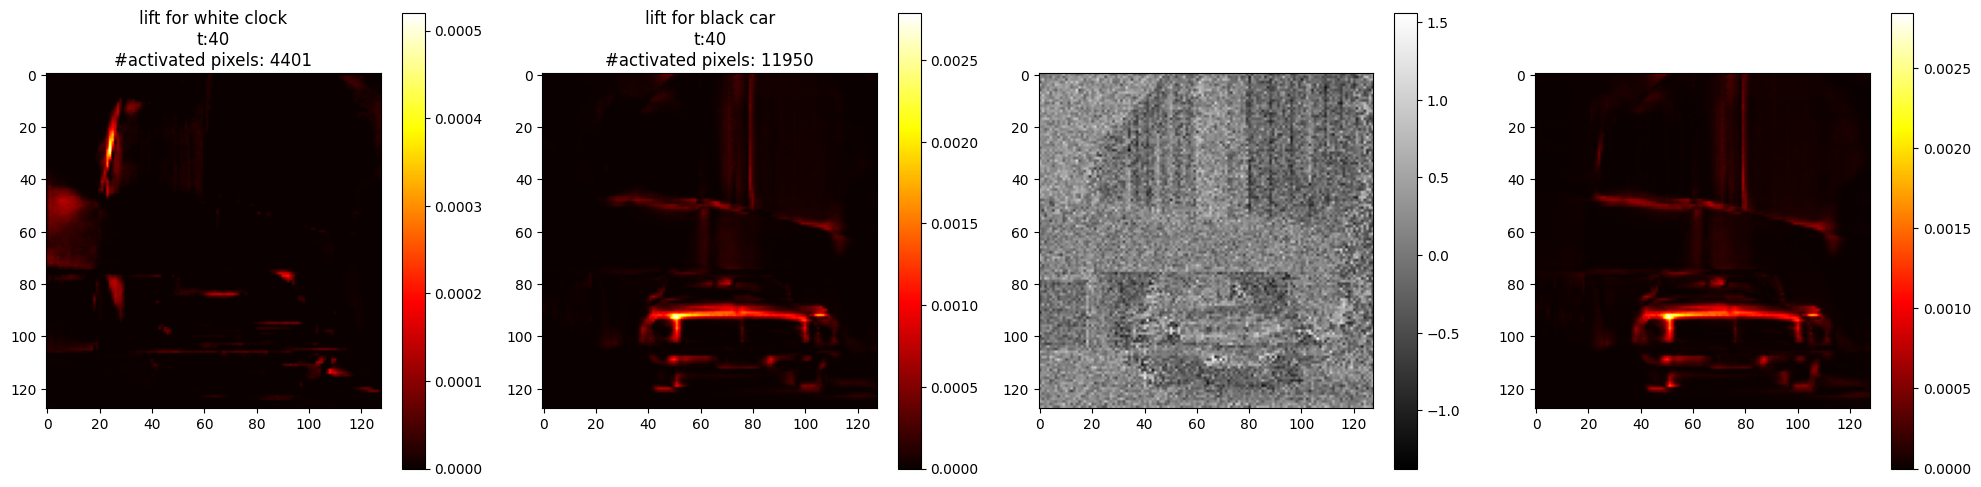

IndexError: index 60 is out of bounds for dimension 0 with size 49

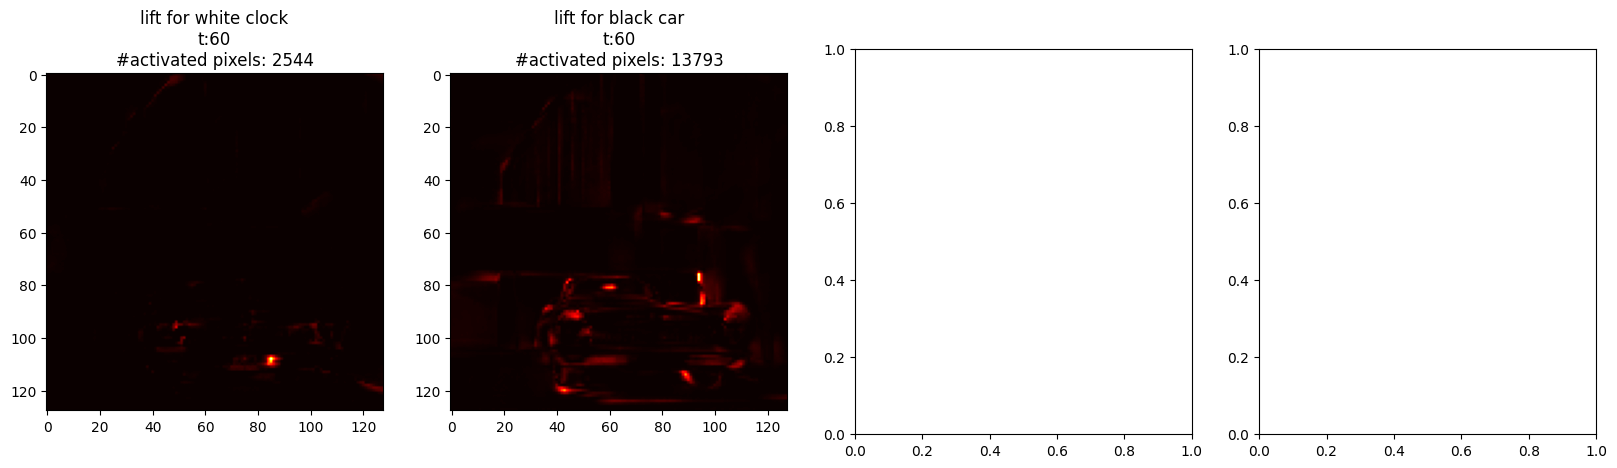

In [91]:
for t in range(score_black_car_and_white_clock_all.shape[1]):
    plt.clf()
    plt.close("all")
    _, ax = plt.subplots(1, 4, figsize=(20, 5))
    img_idx = 3
    score_black_car_and_white_clock_at_t = score_black_car_and_white_clock_all[img_idx, t]
    score_black_car_at_t = score_black_car_all[img_idx, t]
    score_white_clock_at_t = score_white_clock_all[img_idx, t]

    lift_for_white_clock = (score_black_car_and_white_clock_at_t - score_black_car_at_t).pow(2) - (score_black_car_and_white_clock_at_t - score_white_clock_at_t).pow(2)
    lift_for_black_car = (score_black_car_and_white_clock_at_t - score_white_clock_at_t).pow(2) - (score_black_car_and_white_clock_at_t - score_black_car_at_t).pow(2)

    heatmap_for_white_clock = lift_for_white_clock.mean(dim=0).relu().cpu().numpy()
    heatmap_for_black_car = lift_for_black_car.mean(dim=0).relu().cpu().numpy()
    im0 = ax[0].imshow(heatmap_for_white_clock, cmap="hot")
    ax[0].set_title(f"lift for white clock\nt:{t}\n#activated pixels: {(heatmap_for_white_clock > 0).sum().item()}")
    im1 = ax[1].imshow(heatmap_for_black_car, cmap="hot")
    ax[1].set_title(f"lift for black car\nt:{t}\n#activated pixels: {(heatmap_for_black_car > 0).sum().item()}")
    latent = scaled_intermediate_latents[img_idx][t].mean(dim=0)
    im2 = ax[2].imshow(latent.cpu().numpy(), cmap="gray")
    scale_for_black_car = (score_black_car_and_white_clock_at_t - score_white_clock_at_t).pow(2).mean(dim=0).cpu().numpy()
    im3 = ax[3].imshow(scale_for_black_car, cmap="hot")    
    plt.colorbar(im0, ax=ax[0])
    plt.colorbar(im1, ax=ax[1])
    plt.colorbar(im2, ax=ax[2])
    plt.colorbar(im3, ax=ax[3])
    plt.tight_layout()
    plt.show()

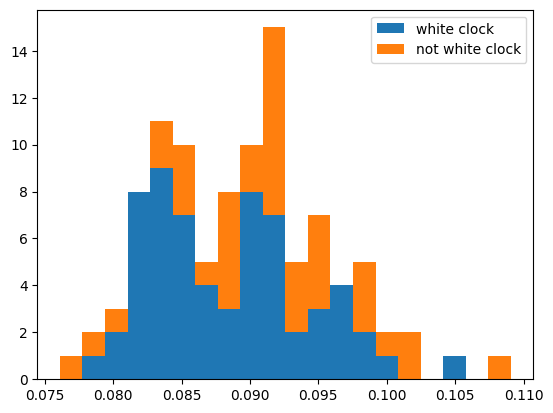

In [25]:
# print the histogram of the logp_white_clock_all
import matplotlib.pyplot as plt
logp_white_clock = logp_white_clock_all.mean(dim=-1).cpu().numpy()
logp_no_white_clock = logp_no_white_clock_all.mean(dim=-1).cpu().numpy()
logp_white_clock_is_white_clock = logp_white_clock[is_white_clock]
logp_white_clock_is_not_white_clock = logp_white_clock[~is_white_clock]
plt.hist([logp_white_clock_is_white_clock, logp_white_clock_is_not_white_clock], stacked=True, label=["white clock", "not white clock"], bins=20)
plt.legend()
plt.show()